# ◆Forex forecast USD／JPY
### Based on [USD / JPY daily forecast](https://stooq.com/q/d/?s=usdjpy&c=0), we predict whether the closing price of the next day will rise or fall.
###### Create Date：2020/01/15　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

#### 【table of contents】
- 0.[**Import module**](#Import_module)
- 1.[**Import data**](#Import_data)
- 2.[**Feature engineering**](#Future_engineering)
- 3.[**Setting the objective variable**](#Setting_the_objective_variable)
- 4.[**Preprocessing**](#Preprocessing)
- 5.[**Modeling**](#Modeling)

###### ※usdjpy_d.csv

| No | Column | ColumnName | Missing | use |
|:---:|:---:|:---:|:---:|:---:|
|  1 | Date| 日付 | - | ○ |
|  2 | Open |始値 | - | ○ |
|  3 | High |高値 | - | ○ |
|  4 | Low |底値 | - | ○ |
|  5 | Close |終値 | - | ○ |

## 0. Import module<a id='Import_module'></a>

In [1]:
%matplotlib inline
#import datetime
from datetime         import datetime
import oandapy
import pytz
import configparser
import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost           as xgb
import lightgbm          as lgb
import category_encoders as ce
import matplotlib.pyplot as plt
from time                    import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from sklearn.metrics         import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from IPython.display         import Markdown, display
from matplotlib import ticker
from sklearn.tree              import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble          import RandomForestClassifier
from sklearn.ensemble          import ExtraTreesClassifier
from sklearn.ensemble          import AdaBoostClassifier
from sklearn.ensemble          import GradientBoostingClassifier
from sklearn.ensemble          import VotingClassifier
from xgboost.sklearn           import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection   import learning_curve
from sklearn.model_selection   import validation_curve

import pandas as pd
import matplotlib.dates as mdates
import codecs as cd
import warnings
warnings.filterwarnings('ignore')

# ****************************************************************************
# setting
# ****************************************************************************
train_size = 0.80

wrapper_flg = True
selectFromModel_flg = False

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)

config = configparser.ConfigParser()
config.read('./config_OANDA.txt')
account_id = config['oanda']['account_id']
api_key = config['oanda']['api_key']

# ============================================================================
# MarkDown
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))

# ============================================================================
# Conv Japan Time
# ============================================================================
def iso_to_jp(iso):
    date = None
    try:
        date = datetime.strptime(iso, '%Y-%m-%dT%H:%M:%S.%fZ')
        date = pytz.utc.localize(date).astimezone(pytz.timezone("Asia/Tokyo"))
    except ValueError:
        try:
            date = datetime.strptime(iso, '%Y-%m-%dT%H:%M:%S.%f%z')
            date = date.astimezone(pytz.timezone("Asia/Tokyo"))
        except ValueError:
            pass
    return date

# ============================================================================
# Conv Format
# ============================================================================
def date_to_str(date):
    if date is None:
        return ''
    return date.strftime('%Y/%m/%d %H:%M:%S')

# ============================================================================
# get_tilt
# ============================================================================
def get_tilt(close):
    
    length = len(close)
    tilt = np.zeros(length)
    
    for i in range(length):
        if i < 1:
            tilt[i] = 0
        else :
            a = pd.Series(close)[i:i+1].values - pd.Series(close)[i-1:i].values
            tilt[i] = a/1
    return tilt

# ============================================================================
# get_rsi
# ============================================================================
def get_rsi(close, period):
    
    diff = close.diff()
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    up_sma = up.rolling(window=period, center=False).mean()
    down_sma = down.abs().rolling(window=period, center=False).mean()
    
    rs = up_sma / down_sma
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

# ============================================================================
# get_rci
# ============================================================================
def get_rci(close, period):
    rank_period = np.arange(period, 0, -1)
    length = len(close)
    rci = np.zeros(length)
    
    for i in range(length):
        if i < period - 1:
            rci[i] = 0
        else :
            rank_price = pd.Series(close)[i - period + 1: i + 1].rank(method='min', ascending = False).values
            rci[i] = np.int32((1 - (6 * sum((rank_period - rank_price)**2)) / (period**3 - period)) * 100)
            
    return rci

# ============================================================================
# get_bb
# ============================================================================
def get_bb(close, sigma):
    mean = close.rolling(window=21).mean()
    std = close.rolling(window=21).std()
    upper = mean + (std * sigma)
    lower = mean - (std * sigma)
    return upper,lower

# ============================================================================
# get_momentum
# ============================================================================
def get_momentum(close, period):
    return close - close.shift(period)

# ============================================================================
# get_sma
# ============================================================================
def get_sma(close, period):
    return list(pd.Series(close).rolling(period).mean())

# ============================================================================
# get_ema
# ============================================================================
def get_ema(close, period):
    return list(pd.Series(close).ewm(span=period).mean())

# ============================================================================
# 学習曲線を作成
# モデル、タイトル、X,y
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# ============================================================================
# 特徴量の重要度を表示するグラフ
# ============================================================================
def plot_feature_importance(best_model, datacols, title):
    plt.figure(figsize=(8,4))
    tmp_se = pd.Series(best_model.feature_importances_,datacols).sort_values(ascending=True)
    tmp_se.tail(15).plot.barh(width=0.8)
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.title(title + ' (Top15)')
    plt.show()
    
# ============================================================================
# ハイパーパラメーター探索用関数
# ============================================================================
def grid_search_argo(dic_argo, model_name, clf, param, X_train, y_train):
    
    # グリッドサーチ
    grid = GridSearchCV(estimator=clf, param_grid=param, scoring='accuracy', cv=kfold, n_jobs=-1)
    
    # 学習
    grid_result = grid.fit(X_train, y_train)

    best_estimator = grid_result.best_estimator_
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    #for mean, stdev, param in zip(means, stds, params):
    #    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    #    print("----------------------------------------------")
    
    print("BestScore: %f using %s" % (round(grid_result.best_score_,3), grid_result.best_params_))
    dic_argo.setdefault(model_name, grid_result) # 辞書に格納
    
    return best_estimator

# 1. Import data<a id='Import_data'></a>

- M30・・・30 minute candlesticks, hour alignment
- H1・・・1 hour candlesticks, hour alignment
- H4・・・4 hour candlesticks, day alignment
- D・・・1 day candlesticks, day alignment
- W・・・1 week candlesticks, aligned to start of week
- M・・・1 month candlesticks, aligned to first day of the month

In [2]:
oa = oandapy.API(environment="live", access_token=api_key)
data = oa.get_history(instrument="USD_JPY", granularity='H4', count=1000)

df = pd.DataFrame(data["candles"])

df['time'] = df['time'].apply(lambda x: iso_to_jp(x))   # 日本時間に変換
df['time'] = df['time'].apply(lambda x: date_to_str(x)) # 形式変換（文字列型）
df["time"] = pd.to_datetime(df["time"])                  # 型変換
#df["time"] = df["time"].apply(mdates.date2num)          # 数値変換

df = df[["time","openAsk","highAsk","lowAsk","closeAsk"]].copy()
df = df.rename(columns={"openAsk":"open","highAsk":"high","lowAsk":"low","closeAsk":"close"})
#df = df.set_index("time")

'''
# ********* Enter today *********
# 本日分を入力して、翌日終値が当日終値よりも上昇するかを予測を行う（ただし、当日の終値は途中）
p_open = 109.587
p_high = 110.016
p_low = 109.813
p_close = 109.903
tmp_se = pd.Series([datetime.today().strftime("%Y-%m-%d 00:00:00"),p_open,p_high,p_low,p_close], index=df.columns)    
df = df.append(tmp_se, ignore_index=True)
df['time'] = pd.to_datetime(df['time'])
# *******************************
'''

print('df.shape=',df.shape)
display(df.tail(2))

df.shape= (1000, 5)


,time,open,high,low,close
998,2020-02-07 23:00:00,109.780,109.852,109.538,109.813
999,2020-02-08 03:00:00,109.812,109.853,109.707,109.799


# 2. Feature engineering <a id ='Future_engineering'></a>

In [3]:
# sma/ema
df['sma5']= get_sma(df.close,5)
df['sma21']= get_sma(df.close,21)
df['ema10']= get_ema(df.close,10)

# tilt(sma/ema)
df['tilt_sma5']= get_tilt(df.sma5)
df['tilt_sma21']= get_tilt(df.sma21)
df['tilt_ema10']= get_tilt(df.ema10)

# BB
df['bb1_up'], df['bb1_low'] = get_bb(df.close, 2)
df['bb2_up'], df['bb2_low'] = get_bb(df.close, 2)
df['bb3_up'], df['bb3_low'] = get_bb(df.close, 2)

# Bollinger band contraction
df['bb1_shrinkage'] = df['bb1_up'] - df['bb1_low']
df['bb2_shrinkage'] = df['bb2_up'] - df['bb2_low']
df['bb3_shrinkage'] = df['bb3_up'] - df['bb3_low']

# momentum
df['momentum_5'] = get_momentum(df.close, 5)
df['momentum_10'] = get_momentum(df.close, 10)
df['momentum_21'] = get_momentum(df.close, 21)

# RCI
df['rci9'] = get_rci(df.close,9)
df['rci21'] = get_rci(df.close,21)
df['rci52'] = get_rci(df.close,52)

# tilt(RCI)
df['tilt_rci9'] = get_tilt(df.rci9)
df['tilt_rci21'] = get_tilt(df.rci21)
df['tilt_rci52'] = get_tilt(df.rci52)

# RSI
df['rsi14'] = get_rsi(df.close,14)
df['tilt_rsi14'] = get_tilt(df.rsi14)

# Candlestick features
df['day_chg'] = df.close - df.open # Daily change
df['c_up'] = np.where(df.day_chg >= 0,1,0) # 陽線：1／陰線：0
df['c_all_len'] = abs(df.high - df.low) # Candle length(ヒゲ含む)
df['c_pil_len'] = np.where(df.day_chg >= 0,df.close - df.open,df.open - df.close) # Candle length
df['top_bar'] = np.where(df.day_chg >= 0,df.high - df.close, df.high - df.open) # 上ヒゲの長さ
df['low_bar'] = np.where(df.day_chg >= 0,df.open - df.low, df.close - df.low)   # 下ヒゲの長さ

# https://east-fx.com/archives/553
dic_c = {'c_y_b':'陽の丸坊主',
         'c_y_dai':'大陽線',
         'c_y_h_b':'陽の大引け坊主',
         'c_y_y_b':'陽の寄り付き坊主',
         'c_y_sg':'下影陽線',
         'c_y_ug':'上影陽線',
         'c_y_km':'陽のコマ',
         'c_y_kk':'陽のカラカサ',
         'c_i_b':'陰の丸坊主',
         'c_i_dai':'大陰線',
         'c_i_y_b':'陰の寄り付き坊主',
         'c_i_h_i':'陰の大引け陰線',
         'c_i_sg':'下影陰線',
         'c_i_km':'陰のコマ',
         'c_i_ug':'上影陰線',
         'c_i_kk':'陰のカラカサ',
         'c_juji':'十字',
         'c_tonbo':'トンボ',
         'c_touba':'トウバ',
         'c_ippon':'一本線'
         }

# 陽の丸坊主(ヒゲがなく実体が長い陽線。買い勢力がかなり強い形)
df['c_y_b'] = np.where((df.c_up == 1) & (df.top_bar < 0.05) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 大陽線(上下ヒゲはあるが実体が長い陽線。買い勢力がかなり強い形。)
df['c_y_dai'] = np.where((df.c_up == 1) & (df.top_bar >= 0.05) & (df.low_bar >= 0.05) & (df.c_pil_len >= 0.6), 1 , 0)
# 陽の大引け坊主(上ヒゲがなく、下ヒゲがある。買いの勢いがまだまだ強い形。)
df['c_y_h_b'] = np.where((df.c_up == 1) & (df.top_bar < 0.05) & (df.low_bar >= 0.10) & (df.c_pil_len >= 0.4), 1 , 0)
# 陽の寄り付き坊主(上ヒゲのみの陽線。買い勢力が強いが、上ヒゲが長すぎると天井になる可能性もある形。)
df['c_y_y_b'] = np.where((df.c_up == 1) & (df.top_bar >= 0.10) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 下影陽線(実体よりも下ヒゲが長い形。一旦売り勢力に攻め込まれてからの戻しの長いヒゲなので、買い勢力が強い。)
df['c_y_sg'] = np.where((df.c_up == 1) & (df.low_bar >= 0.40) & (df.low_bar > df.c_pil_len), 1 , 0)
# 上影陽線(実体よりも上ヒゲが長い形。買い勢力が売り勢力に押され気味になり上ヒゲになるので、買い勢力が若干弱め。実体が短すぎ場合はトレンド転換の可能性あり。)
df['c_y_ug'] = np.where((df.c_up == 1) & (df.top_bar >= 0.40) & (df.top_bar > df.c_pil_len), 1 , 0)
# 陽のコマ(保ち合い。売り買いの勢力が拮抗している状態で現れる。陽線の場合は強持ち合いと呼ばれる。トレンド転換の可能性あり。)
df['c_y_km'] = np.where((df.c_up == 1) & (df.top_bar < 0.10) & (df.low_bar < 0.10) & (df.c_pil_len < 0.20), 1 , 0)
# 陽のカラカサ(下ヒゲが長く、実体がヒゲよりも小さい形。トレンド転換する可能性あり。)
df['c_y_kk'] = np.where((df.c_up == 1) & (df.low_bar >= 0.40) & (df.top_bar < 0.05) & (df.c_pil_len < df.low_bar), 1 , 0)

# 陰の丸坊主(ヒゲがなく実体が長い陰線。売り勢力がかなり強い形)
df['c_i_b'] = np.where((df.c_up == 0) & (df.top_bar < 0.05) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 大陰線(上下ヒゲはあるが実体が長い陰線。売り勢力がかなり強い形。)
df['c_i_dai'] = np.where((df.c_up == 0) & (df.top_bar >= 0.05) & (df.low_bar >= 0.05) & (df.c_pil_len >= 0.6), 1 , 0)
# 陰の寄り付き坊主(上ヒゲがない陰線。実体部分が長いので売り勢力優勢ではあるが、下ヒゲが長すぎるとトレンド転換の可能性あり。)
df['c_i_y_b'] = np.where((df.c_up == 0) & (df.top_bar < 0.05) & (df.low_bar >= 0.10) & (df.c_pil_len >= 0.4), 1 , 0)
# 陰の大引け陰線(下ヒゲがない形。実体部分が長く売り勢力の勢いも強い。)
df['c_i_h_i'] = np.where((df.c_up == 0) & (df.top_bar >= 0.10) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 下影陰線(下ヒゲが長く実体がヒゲよりも短い陰線。売りの勢力が少し弱まっている際に出現しやすいので、トレンド転換する可能性あり。)
df['c_i_sg'] = np.where((df.c_up == 0) & (df.low_bar >= 0.40) & (df.low_bar > df.c_pil_len), 1 , 0)
# 陰のコマ(売り・買い勢力が拮抗している形。陰線の場合は弱持合いと呼ばれている。)
df['c_i_km'] = np.where((df.c_up == 0) & (df.top_bar < 0.10) & (df.low_bar < 0.10) & (df.c_pil_len < 0.2), 1 , 0)
# 上影陰線(上ヒゲが長く実体がヒゲより短い形。一旦買い勢力に押し戻されてから再度ヒゲをつけて戻しているので、売り勢力が強い。ただ、実体が短すぎるとトレンド転換の可能性もある。)
df['c_i_ug'] = np.where((df.c_up == 0) & (df.top_bar >= 0.40) & (df.top_bar > df.c_pil_len), 1 , 0)
# 陰のカラカサ(下ヒゲが長く上ヒゲがなく、且つ実体が短い形。)
df['c_i_kk'] = np.where((df.c_up == 0) & (df.low_bar >= 0.40) & (df.top_bar < 0.05) & (df.c_pil_len < df.low_bar), 1 , 0)

# 十字（天井もしくは底ならトレンド転換の可能性あり。）
df['c_juji'] = np.where((df.c_pil_len < 0.1) & (abs(df.top_bar - df.low_bar) <= 0.1) & (df.c_pil_len < 0.1), 1 , 0)
# トンボ（天井もしくは底ならトレンド転換の可能性あり。）
df['c_tonbo'] = np.where((df.top_bar < 0.05) & (df.low_bar >= 0.2) & (df.c_pil_len < 0.1), 1 , 0)
# トウバ(天井もしくは底ならトレンド転換の可能性あり。)
df['c_touba'] = np.where((df.low_bar < 0.05) & (df.top_bar >= 0.2) & (df.c_pil_len < 0.1), 1 , 0)
# 一本線(継続トレンド転換の可能性あり)
df['c_ippon'] = np.where((df.low_bar < 0.05) & (df.top_bar < 0.05) & (df.c_pil_len < 0.1), 1 , 0)

# Candlestick features for the last few days
df['y1_day_chg'] = df.day_chg.shift(+1)
df['y1_c_all_len'] = df.c_all_len.shift(+1)
df['y1_c_pil_len'] = df.c_pil_len.shift(+1)
df['y1_c_up'] = df.c_up.shift(+1)
df['y1_top_bar'] = df.top_bar.shift(+1)
df['y1_low_bar'] = df.low_bar.shift(+1)

df['y2_day_chg'] = df.day_chg.shift(+2)
df['y2_c_all_len'] = df.c_all_len.shift(+2)
df['y2_c_pil_len'] = df.c_pil_len.shift(+2)
df['y2_c_up'] = df.c_up.shift(+2)
df['y2_top_bar'] = df.top_bar.shift(+2)
df['y2_low_bar'] = df.low_bar.shift(+2)

df['y3_day_chg'] = df.day_chg.shift(+3)
df['y3_c_all_len'] = df.c_all_len.shift(+3)
df['y3_c_pil_len'] = df.c_pil_len.shift(+3)
df['y3_c_up'] = df.c_up.shift(+3)
df['y3_top_bar'] = df.top_bar.shift(+3)
df['y3_low_bar'] = df.low_bar.shift(+3)

df['y4_day_chg'] = df.day_chg.shift(+4)
df['y4_c_all_len'] = df.c_all_len.shift(+4)
df['y4_c_pil_len'] = df.c_pil_len.shift(+4)
df['y4_c_up'] = df.c_up.shift(+4)
df['y4_top_bar'] = df.top_bar.shift(+4)
df['y4_low_bar'] = df.low_bar.shift(+4)

df['y5_day_chg'] = df.day_chg.shift(+5)
df['y5_c_all_len'] = df.c_all_len.shift(+5)
df['y5_c_pil_len'] = df.c_pil_len.shift(+5)
df['y5_c_up'] = df.c_up.shift(+5)
df['y5_top_bar'] = df.top_bar.shift(+5)
df['y5_low_bar'] = df.low_bar.shift(+5)

df['ren2_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1), 1 , 0)
df['ren3_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1), 1 , 0)
df['ren4_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1) & (df.y3_c_up == 1), 1 , 0)
df['ren5_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1) & (df.y3_c_up == 1) & (df.y4_c_up == 1), 1 , 0)
df['ren6_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1) & (df.y3_c_up == 1) & (df.y4_c_up == 1) & (df.y5_c_up == 1), 1 , 0)

df['ren2_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0), 1 , 0)
df['ren3_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0), 1 , 0)
df['ren4_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0) & (df.y3_c_up == 0), 1 , 0)
df['ren5_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0) & (df.y3_c_up == 0) & (df.y4_c_up == 0), 1 , 0)
df['ren6_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0) & (df.y3_c_up == 0) & (df.y4_c_up == 0) & (df.y5_c_up == 0), 1 , 0)

# test target
df = df.query('time >= "2019-12-01"')

printmd('▼ size')
display(df.shape)

printmd('▼ Last 5 lines display')
display(df.tail(5))



**▼ size**

(288, 97)



**▼ Last 5 lines display**

,time,open,high,low,close,sma5,sma21,ema10,tilt_sma5,tilt_sma21,tilt_ema10,bb1_up,bb1_low,bb2_up,bb2_low,bb3_up,bb3_low,bb1_shrinkage,bb2_shrinkage,bb3_shrinkage,momentum_5,momentum_10,momentum_21,rci9,rci21,rci52,tilt_rci9,tilt_rci21,tilt_rci52,rsi14,tilt_rsi14,day_chg,c_up,c_all_len,c_pil_len,top_bar,low_bar,c_y_b,c_y_dai,c_y_h_b,c_y_y_b,c_y_sg,c_y_ug,c_y_km,c_y_kk,c_i_b,c_i_dai,c_i_y_b,c_i_h_i,c_i_sg,c_i_km,c_i_ug,c_i_kk,c_juji,c_tonbo,c_touba,c_ippon,y1_day_chg,y1_c_all_len,y1_c_pil_len,y1_c_up,y1_top_bar,y1_low_bar,y2_day_chg,y2_c_all_len,y2_c_pil_len,y2_c_up,y2_top_bar,y2_low_bar,y3_day_chg,y3_c_all_len,y3_c_pil_len,y3_c_up,y3_top_bar,y3_low_bar,y4_day_chg,y4_c_all_len,y4_c_pil_len,y4_c_up,y4_top_bar,y4_low_bar,y5_day_chg,y5_c_all_len,y5_c_pil_len,y5_c_up,y5_top_bar,y5_low_bar,ren2_up,ren3_up,ren4_up,ren5_up,ren6_up,ren2_down,ren3_down,ren4_down,ren5_down,ren6_down
995,2020-02-07 11:00:00,109.921,109.944,109.880,109.891,109.9362,109.565810,109.840713,0.0068,0.058095,0.011175,110.411458,108.720161,110.411458,108.720161,110.411458,108.720161,1.691297,1.691297,1.691297,0.034,0.107,1.220,63.0,95.0,51.0,-20.0,-2.0,4.0,68.678460,-3.911902,-0.030,0,0.064,0.030,0.023,0.011,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,-0.079,0.225,0.079,0.0,0.047,0.099,0.025,0.061,0.025,1.0,0.006,0.030,0.088,0.169,0.088,1.0,0.017,0.064,0.032,0.154,0.032,1.0,0.052,0.070,-0.057,0.177,0.057,0.0,0.063,0.057,0,0,0,0,0,1,0,0,0,0
996,2020-02-07 15:00:00,109.890,110.001,109.785,109.790,109.9164,109.616714,109.831492,-0.0198,0.050905,-0.009220,110.372723,108.860706,110.372723,108.860706,110.372723,108.860706,1.512018,1.512018,1.512018,-0.099,0.019,1.069,9.0,90.0,54.0,-54.0,-5.0,3.0,64.579256,-4.099204,-0.100,0,0.216,0.100,0.111,0.005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.030,0.064,0.030,0.0,0.023,0.011,-0.079,0.225,0.079,0.0,0.047,0.099,0.025,0.061,0.025,1.0,0.006,0.030,0.088,0.169,0.088,1.0,0.017,0.064,0.032,0.154,0.032,1.0,0.052,0.070,0,0,0,0,0,1,1,0,0,0
997,2020-02-07 19:00:00,109.788,110.049,109.678,109.781,109.8770,109.667810,109.822312,-0.0394,0.051095,-0.009180,110.300921,109.034698,110.300921,109.034698,110.300921,109.034698,1.266222,1.266222,1.266222,-0.197,-0.082,1.073,-36.0,81.0,56.0,-45.0,-9.0,2.0,67.415730,2.836474,-0.007,0,0.371,0.007,0.261,0.103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.100,0.216,0.100,0.0,0.111,0.005,-0.030,0.064,0.030,0.0,0.023,0.011,-0.079,0.225,0.079,0.0,0.047,0.099,0.025,0.061,0.025,1.0,0.006,0.030,0.088,0.169,0.088,1.0,0.017,0.064,0,0,0,0,0,1,1,1,0,0
998,2020-02-07 23:00:00,109.780,109.852,109.538,109.813,109.8388,109.715000,109.820619,-0.0382,0.047190,-0.001693,110.217607,109.212393,110.217607,109.212393,110.217607,109.212393,1.005214,1.005214,1.005214,-0.191,-0.026,0.991,-51.0,73.0,60.0,-15.0,-8.0,4.0,57.295850,-10.119880,0.033,1,0.314,0.033,0.039,0.242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.007,0.371,0.007,0.0,0.261,0.103,-0.100,0.216,0.100,0.0,0.111,0.005,-0.030,0.064,0.030,0.0,0.023,0.011,-0.079,0.225,0.079,0.0,0.047,0.099,0.025,0.061,0.025,1.0,0.006,0.030,0,0,0,0,0,0,0,0,0,0
999,2020-02-08 03:00:00,109.812,109.853,109.707,109.799,109.8148,109.748667,109.816688,-0.0240,0.033667,-0.003931,110.162960,109.334373,110.162960,109.334373,110.162960,109.334373,0.828587,0.828587,0.828587,-0.120,-0.117,0.707,-68.0,63.0,62.0,-17.0,-10.0,2.0,51.101322,-6.194528,-0.013,0,0.146,0.013,0.041,0.092,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.033,0.314,0.033,1.0,0.039,0.242,-0.007,0.371,0.007,0.0,0.261,0.103,-0.100,0.216,0.100,0.0,0.111,0.005,-0.030,0.064,0.030,0.0,0.023,0.011,-0.079,0.225,0.079,0.0,0.047,0.099,0,0,0,0,0,0,0,0,0,0


In [4]:
# Check number of data of candlestick features
for k,v in dic_c.items():
    printmd('▼' + str(k) + ':' + str(v))
    print(df[k].value_counts())
    #tmp_df = df.query(k + '== 1').head(10)
    #display(tmp_df[['time','open','high','low','close']])



**▼c_y_b:陽の丸坊主**

0    287
1      1
Name: c_y_b, dtype: int64




**▼c_y_dai:大陽線**

0    288
Name: c_y_dai, dtype: int64




**▼c_y_h_b:陽の大引け坊主**

0    288
Name: c_y_h_b, dtype: int64




**▼c_y_y_b:陽の寄り付き坊主**

0    288
Name: c_y_y_b, dtype: int64




**▼c_y_sg:下影陽線**

0    288
Name: c_y_sg, dtype: int64




**▼c_y_ug:上影陽線**

0    288
Name: c_y_ug, dtype: int64




**▼c_y_km:陽のコマ**

0    174
1    114
Name: c_y_km, dtype: int64




**▼c_y_kk:陽のカラカサ**

0    288
Name: c_y_kk, dtype: int64




**▼c_i_b:陰の丸坊主**

0    288
Name: c_i_b, dtype: int64




**▼c_i_dai:大陰線**

0    288
Name: c_i_dai, dtype: int64




**▼c_i_y_b:陰の寄り付き坊主**

0    287
1      1
Name: c_i_y_b, dtype: int64




**▼c_i_h_i:陰の大引け陰線**

0    288
Name: c_i_h_i, dtype: int64




**▼c_i_sg:下影陰線**

0    288
Name: c_i_sg, dtype: int64




**▼c_i_km:陰のコマ**

0    196
1     92
Name: c_i_km, dtype: int64




**▼c_i_ug:上影陰線**

0    288
Name: c_i_ug, dtype: int64




**▼c_i_kk:陰のカラカサ**

0    288
Name: c_i_kk, dtype: int64




**▼c_juji:十字**

1    186
0    102
Name: c_juji, dtype: int64




**▼c_tonbo:トンボ**

0    287
1      1
Name: c_tonbo, dtype: int64




**▼c_touba:トウバ**

0    288
Name: c_touba, dtype: int64




**▼c_ippon:一本線**

0    200
1     88
Name: c_ippon, dtype: int64


# 3. Setting the objective variable<a id= 'Setting_the_objective_variable'></a>



**▼ target（%）**

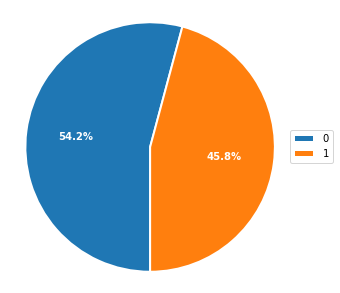

,target
0,156
1,132


,time,open,high,low,close,sma5,sma21,ema10,tilt_sma5,tilt_sma21,tilt_ema10,bb1_up,bb1_low,bb2_up,bb2_low,bb3_up,bb3_low,bb1_shrinkage,bb2_shrinkage,bb3_shrinkage,momentum_5,momentum_10,momentum_21,rci9,rci21,rci52,tilt_rci9,tilt_rci21,tilt_rci52,rsi14,tilt_rsi14,day_chg,c_up,c_all_len,c_pil_len,top_bar,low_bar,c_y_b,c_y_dai,c_y_h_b,c_y_y_b,c_y_sg,c_y_ug,c_y_km,c_y_kk,c_i_b,c_i_dai,c_i_y_b,c_i_h_i,c_i_sg,c_i_km,c_i_ug,c_i_kk,c_juji,c_tonbo,c_touba,c_ippon,y1_day_chg,y1_c_all_len,y1_c_pil_len,y1_c_up,y1_top_bar,y1_low_bar,y2_day_chg,y2_c_all_len,y2_c_pil_len,y2_c_up,y2_top_bar,y2_low_bar,y3_day_chg,y3_c_all_len,y3_c_pil_len,y3_c_up,y3_top_bar,y3_low_bar,y4_day_chg,y4_c_all_len,y4_c_pil_len,y4_c_up,y4_top_bar,y4_low_bar,y5_day_chg,y5_c_all_len,y5_c_pil_len,y5_c_up,y5_top_bar,y5_low_bar,ren2_up,ren3_up,ren4_up,ren5_up,ren6_up,ren2_down,ren3_down,ren4_down,ren5_down,ren6_down,t1_close,t1_diff,target
997,2020-02-07 19:00:00,109.788,110.049,109.678,109.781,109.8770,109.667810,109.822312,-0.0394,0.051095,-0.009180,110.300921,109.034698,110.300921,109.034698,110.300921,109.034698,1.266222,1.266222,1.266222,-0.197,-0.082,1.073,-36.0,81.0,56.0,-45.0,-9.0,2.0,67.415730,2.836474,-0.007,0,0.371,0.007,0.261,0.103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.100,0.216,0.100,0.0,0.111,0.005,-0.030,0.064,0.030,0.0,0.023,0.011,-0.079,0.225,0.079,0.0,0.047,0.099,0.025,0.061,0.025,1.0,0.006,0.030,0.088,0.169,0.088,1.0,0.017,0.064,0,0,0,0,0,1,1,1,0,0,109.813,0.032,1
998,2020-02-07 23:00:00,109.780,109.852,109.538,109.813,109.8388,109.715000,109.820619,-0.0382,0.047190,-0.001693,110.217607,109.212393,110.217607,109.212393,110.217607,109.212393,1.005214,1.005214,1.005214,-0.191,-0.026,0.991,-51.0,73.0,60.0,-15.0,-8.0,4.0,57.295850,-10.119880,0.033,1,0.314,0.033,0.039,0.242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.007,0.371,0.007,0.0,0.261,0.103,-0.100,0.216,0.100,0.0,0.111,0.005,-0.030,0.064,0.030,0.0,0.023,0.011,-0.079,0.225,0.079,0.0,0.047,0.099,0.025,0.061,0.025,1.0,0.006,0.030,0,0,0,0,0,0,0,0,0,0,109.799,-0.014,0
999,2020-02-08 03:00:00,109.812,109.853,109.707,109.799,109.8148,109.748667,109.816688,-0.0240,0.033667,-0.003931,110.162960,109.334373,110.162960,109.334373,110.162960,109.334373,0.828587,0.828587,0.828587,-0.120,-0.117,0.707,-68.0,63.0,62.0,-17.0,-10.0,2.0,51.101322,-6.194528,-0.013,0,0.146,0.013,0.041,0.092,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.033,0.314,0.033,1.0,0.039,0.242,-0.007,0.371,0.007,0.0,0.261,0.103,-0.100,0.216,0.100,0.0,0.111,0.005,-0.030,0.064,0.030,0.0,0.023,0.011,-0.079,0.225,0.079,0.0,0.047,0.099,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0


In [5]:
# 翌日終値が当日終値よりも上昇するかを予測
df['t1_close'] = df.close.shift(-1)
df['t1_diff'] = df['t1_close'] - df['close']
df['target'] = np.where(df['t1_diff'] >= 0.01,1,0)

printmd('▼ target（%）')
per_state = round(df['target'].value_counts() / len(df['target']) * 100,2)
values = list(per_state.values)

# pie
plt.figure(figsize=(5,5))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=270,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

display(pd.DataFrame(df['target'].value_counts(),columns=['target']))

display(df.tail(3))

# 4. Preprocessing<a id ='Preprocessing'></a>

In [6]:
# データセットの行数、列数を取得
split_row = np.int(train_size * df.shape[0])
end_row = df.shape[0]

# 翌日の予測用を保持
X_today_df = df.tail(1)

X_all_df = df.drop(['time','t1_close','t1_diff','target'], axis=1)

X_columns = X_all_df.columns

# 標準化項目リスト
enc_norm_col = ['open','high','low','close',
                'sma5','sma21','ema10',
                'rci9','rci21','rci52',
                'tilt_rci9','tilt_rci21','tilt_rci52',
                'tilt_sma5','tilt_sma21',
                'tilt_ema10',
                'rsi14',
                'tilt_rsi14',
                'bb1_up','bb1_low',
                'bb2_up','bb2_low',
                'bb3_up','bb3_low',
                'bb1_shrinkage','bb2_shrinkage','bb3_shrinkage',
                'momentum_5','momentum_10','momentum_21',
                'day_chg','c_all_len','c_pil_len','top_bar','low_bar',
                'y1_day_chg','y1_c_all_len','y1_c_pil_len','y1_top_bar','y1_low_bar',
                'y2_day_chg','y2_c_all_len','y2_c_pil_len','y2_top_bar','y2_low_bar',
                'y3_day_chg','y3_c_all_len','y3_c_pil_len','y3_top_bar','y3_low_bar',
                'y4_day_chg','y4_c_all_len','y4_c_pil_len','y4_top_bar','y4_low_bar',
                'y5_day_chg','y5_c_all_len','y5_c_pil_len','y5_top_bar','y5_low_bar',
               ]

# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, X_all_df.columns.get_loc(col_name))
X_columns = X_all_df.columns
list_X_columns = X_columns.tolist()

# -------------------------------------------------
# ndarrayに変換
X_all = X_all_df.values
y_all = df['target'].values

printmd('▼全データ')
print('X_all.shape=',X_all.shape)
print('y_all.shape=',y_all.shape)
#print('X_all[-3:,]',X_all[-3:,])

# 訓練用
X_train = X_all[:split_row, :]
y_train = y_all[:split_row]

printmd('▼訓練データ')
print('X_train.shape=',X_train.shape)
print('y_train.shape=',y_train.shape)
#print('X_train[-1:,]=\n',X_train[-1:,])

# テスト用
X_test = X_all[split_row+1:end_row-1,:]
y_test = y_all[split_row+1:end_row-1]

printmd('▼テストデータ')
print('X_test.shape=',X_test.shape)
print('y_test.shape=',y_test.shape)
#print('X_test[-1:,]=\n',X_test[-1:,])

# 翌日の予測用
X_today = X_all[end_row - 1:,:]

printmd('▼予測データ')
print('X_today.shape=',X_today.shape)
#print('X_today.shape=',X_today)

# 標準化
for col_name,col_idx in dic_norm_col.items():
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    X_today[:,col_idx:col_idx+1] = stdsc.transform(X_today[:,col_idx:col_idx+1])
    



**▼全データ**

X_all.shape= (288, 96)
y_all.shape= (288,)




**▼訓練データ**

X_train.shape= (230, 96)
y_train.shape= (230,)




**▼テストデータ**

X_test.shape= (56, 96)
y_test.shape= (56,)




**▼予測データ**

X_today.shape= (1, 96)


# 4-1. 特徴選択<a id='selection'></a>

- 不要な説明変数を除外します。以下の通り、ラッパー法と埋め込み法を試しましたが、速度と精度の観点から、L1正則化を利用したロジスティック回帰モデルで埋め込み法を実施しています。

### 4-1-1. ラッパー法（ステップワイズ法）[RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

→ラッパー法（ステップワイズ法）を実施する


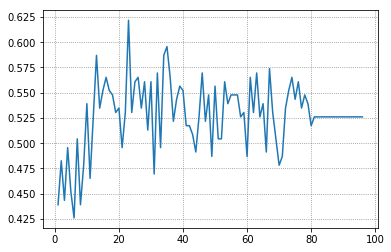

None
│open is dropped. 
│high is dropped. 
│close is dropped. 
│sma5 is dropped. 
│sma21 is dropped. 
│ema10 is dropped. 
│bb1_up is dropped. 
│bb1_low is dropped. 
│bb2_up is dropped. 
│bb1_shrinkage is dropped. 
│bb2_shrinkage is dropped. 
│bb3_shrinkage is dropped. 
│momentum_5 is dropped. 
│momentum_10 is dropped. 
│rci21 is dropped. 
│rci52 is dropped. 
│tilt_rci9 is dropped. 
│tilt_rci21 is dropped. 
│tilt_rci52 is dropped. 
│rsi14 is dropped. 
│tilt_rsi14 is dropped. 
│day_chg is dropped. 
│c_up is dropped. 
│c_all_len is dropped. 
│c_pil_len is dropped. 
│low_bar is dropped. 
│c_y_dai is dropped. 
│c_y_h_b is dropped. 
│c_y_y_b is dropped. 
│c_y_sg is dropped. 
│c_y_ug is dropped. 
│c_y_km is dropped. 
│c_y_kk is dropped. 
│c_i_b is dropped. 
│c_i_dai is dropped. 
│c_i_y_b is dropped. 
│c_i_h_i is dropped. 
│c_i_sg is dropped. 
│c_i_km is dropped. 
│c_i_ug is dropped. 
│c_i_kk is dropped. 
│c_tonbo is dropped. 
│c_touba is dropped. 
│c_ippon is dropped. 
│y1_day_chg is dropped.

In [7]:
if(wrapper_flg):
    print('→ラッパー法（ステップワイズ法）を実施する')
    
    # RFECVは交差検証によってステップワイズ法による特徴選択を行う
    kfold = KFold(n_splits=10, random_state=1234)
    estimator = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
    rfecv = RFECV(estimator, cv=kfold, scoring='accuracy')
    rfecv.fit(X_train, y_train)

    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    print(plt.show())
    
    # 除外する特徴量
    remove_feature = X_columns[ ~rfecv.support_]
    for f in remove_feature:
        list_X_columns.remove(f)
        print('│' + f + ' is dropped. ')

    print('\n▼利用対象の特徴数')
    print('len(list_X_columns)=',len(list_X_columns))   

    X_train = X_train[:,rfecv.support_]
    X_test = X_test[:,rfecv.support_]
    X_today = X_today[:,rfecv.support_]

    print('\n▼ ラッパー法実施後行列')
    print('X_train=',X_train.shape)
    print('X_test=',X_test.shape)
else:
    print('→ラッパー法（ステップワイズ法）しない')


### 4-1-2. 埋め込み法 [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)

In [8]:
if(selectFromModel_flg):
    print('→埋め込み法を実施する')
    
    # ロジスティック回帰のL1正則化によって、特徴選択を行う
    clf = SGDClassifier(loss='log',alpha=0.0001, penalty='l1',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
    sfm = SelectFromModel(clf, threshold=1e-5)
    sfm.fit(X_train, y_train)
    
    # 結果をDataFrameへ格納
    res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
    res_df['feature'] = list_X_columns
    res_df['weight'] = np.reshape(sfm.estimator_.coef_[0], -1).tolist()
    res_df['abs_w'] = abs( res_df['weight'] )

    # 重みの大きさを横棒グラフで表示
    print('\n▼ 重みの大きさを横棒グラフで表示(Top15)')
    res_df = res_df.sort_values('abs_w', ascending=False)
    res_df.reset_index(drop=True,inplace=True)
    res_df_head = res_df.head(15)
    plt.figure(figsize=(10, 5))
    plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
    plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
    plt.title('feature importance')
    plt.xlabel('weight')
    plt.ylabel('feature')
    plt.grid()
    plt.show()
    
    # 除外する特徴量
    remove_feature = X_columns[ ~sfm.get_support()]
    for f in remove_feature:
        list_X_columns.remove(f)
        print('│' + f + ' is dropped. ')

    print('\n▼利用対象の特徴数')
    print('len(list_X_columns)=',len(list_X_columns))   

    X_train = X_train[:,sfm.get_support()]
    X_test = X_test[:,sfm.get_support()]
    X_today = X_today[:,sfm.get_support()]
    
    print('\n▼ 埋め込み法実施後行列')
    print('X_train=',X_train.shape)
    print('X_test=',X_test.shape)
else:
    print('→埋め込み法を実施しない')


→埋め込み法を実施しない


# 5. Modeling<a id='Modeling'></a>

In [9]:
dic_argo = {} # アルゴリズムごとに結果を格納
kfold = KFold(n_splits=5, random_state=1234)

## 5-1. Basic Algorithm

### 5-1-1. [ロジスティック回帰](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [10]:
lr_clf = SGDClassifier(loss='log', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
lr_param = {'penalty' : ['None','l1','l2','elasticnet'],#正則化項（default = 'l2'）
            'alpha' : [1e-4, 1e-3] # 正則化項の効き具合(default = 0.0001:1e-4)
            }
best_lr = grid_search_argo(dic_argo, 'LogisticRegression', lr_clf, lr_param, X_train, y_train)

best_lr

BestScore: 0.622000 using {'alpha': 0.0001, 'penalty': 'None'}


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='None',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

### 5-1-2. [サポートベクターマシン](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [11]:
svm_clf = SVC(random_state=1234,probability=True)
svm_param = [{'kernel': ['linear'], 'C': [0.1,1]},
                  {'kernel': ['rbf'], 'gamma': [0.1, 1e-2],'C': [0.1,1]}
                 ]
best_svm = grid_search_argo(dic_argo, 'SVM', svm_clf, svm_param, X_train, y_train)

best_svm

BestScore: 0.643000 using {'C': 0.1, 'kernel': 'linear'}


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=1234,
  shrinking=True, tol=0.001, verbose=False)

### 5-1-3. [DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [12]:
dt_clf = DecisionTreeClassifier(criterion='gini',random_state=1234)
dt_param = {'splitter':['best','random'],  # default='best' 各ノードで分割を選択するために使用される戦略
            'max_depth' : [2,5],         # 木の深さ
            'min_samples_split': [2,3],    # ノードを分割するために必要な最小サンプルサイズ
            'min_samples_leaf':[1,3],      # 葉を構成するのに必要な最小限のサンプルの数
            }
best_dt = grid_search_argo(dic_argo, 'DecisionTree', dt_clf, dt_param, X_train, y_train)

best_dt

BestScore: 0.574000 using {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'random'}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='random')

## 5-2. アンサンブル法（バギング）
### 5-2-1. [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [13]:
RFC_clf = RandomForestClassifier(random_state=1234)
RFC_param = {'max_depth': [2],    # 木の深さ
             'min_samples_split': [2,3], # ノードを分割するために必要な最小サンプルサイズ
             'min_samples_leaf': [1,3],  # 葉を構成するのに必要な最小限のサンプルの数
             'n_estimators' :[100,200],
            }
best_RFC = grid_search_argo(dic_argo, 'RandomForest', RFC_clf, RFC_param, X_train, y_train)

best_RFC

BestScore: 0.578000 using {'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

## 5-3. アンサンブル法（ブースティング）
### 5-3-1. [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [14]:
ABC_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=1234), random_state=1234)
ABC_param = {"base_estimator__criterion" : ["gini"],
             'base_estimator__max_depth': [2],     # 木の深さ
             'base_estimator__min_samples_split': [2], # ノードを分割するために必要な最小サンプルサイズ
             'base_estimator__min_samples_leaf': [3],  # 葉を構成するのに必要な最小限のサンプルの数
             'n_estimators':[500,800],                 # ブースティングする木の数
             'learning_rate': [0.001]                  # 学習率
            }
best_ABC = grid_search_argo(dic_argo, 'AdaBoost', ABC_clf, ABC_param, X_train, y_train)

best_ABC

BestScore: 0.552000 using {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 2, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_samples_split': 2, 'learning_rate': 0.001, 'n_estimators': 500}


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
          learning_rate=0.001, n_estimators=500, random_state=1234)

### 5-3-2. [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [15]:
GBC_clf = GradientBoostingClassifier(random_state=1234)
GBC_param = {'loss' : ['deviance'],   # 最適化される損失関数
             'n_estimators' : [1200], # ブースティングする木の数
             'learning_rate': [0.05], # 学習率
             'max_depth': [2],        # 木の深さ
             'min_samples_leaf': [1], # 葉を構成するのに必要な最小限のサンプルの数
             'min_samples_split': [2], # 内部ノードを分割するために必要なサンプルの最小数
             'max_features': ['sqrt']  # 最適な分割を探すときに考慮する機能の数
             }
best_GBC = grid_search_argo(dic_argo, 'GradientBoosting', GBC_clf, GBC_param, X_train, y_train)

best_GBC

BestScore: 0.565000 using {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=2,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1200,
              n_iter_no_change=None, presort='auto', random_state=1234,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### 5-3-3. [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [16]:
XGB_clf = xgb.XGBClassifier(objective= 'binary:logistic',random_state=1234)
XGB_param = {'learning_rate': [0.08],   # 学習率
             'max_depth': [2],          # 木の深さ
             'min_child_weight': [1],   # 子ノードにおいて観察されるデータの重み付けの合計
             'subsample': [0.6],        # トレーニングインスタンスのサブサンプル率
             'colsample_bytree': [0.8], # 各木を構築するときの列のサブサンプル比
             'n_estimators': [300],     # ブースティングする木の数
             'gamma':[0.1],             # 木のノードにさらにパーティションを作成するために必要な最小限の損失削減
             'eta': [0.3],              # 学習率を調整できる。小さくすることで、モデルの頑健性を高めることができる。
            }
best_XGB = grid_search_argo(dic_argo, 'XGBoost', XGB_clf, XGB_param, X_train, y_train)

best_XGB

BestScore: 0.548000 using {'colsample_bytree': 0.8, 'eta': 0.3, 'gamma': 0.1, 'learning_rate': 0.08, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.6}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0.1,
       learning_rate=0.08, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=1234,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.6, verbosity=1)

### 4-3-4. [LightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [17]:
LGB_clf = lgb.LGBMClassifier(objective='binary',random_state=1234)
LGB_param ={'n_estimators':[1200],     # ブースティングする木の数
            'max_depth':[2],          # 木の深さ
            'num_leaves':[14],         # 木の葉の最大数
            'learning_rate':[0.01],    # 学習率
            'colsample_bytree':[0.8],  # 各木を構築するときの列のサブサンプル比
            'subsample':[0.01],        # トレーニングインスタンスのサブサンプル率
            'reg_alpha':[0.01],        # 重みに関するL1正則化項
            'reg_lambda':[0],          # 重みに関するL2正則化項
            }
best_LGB = grid_search_argo(dic_argo, 'LightGBM', LGB_clf, LGB_param, X_train, y_train)

best_LGB

BestScore: 0.578000 using {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1200, 'num_leaves': 14, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.01}


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.01, max_depth=2,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1200, n_jobs=-1, num_leaves=14, objective='binary',
        random_state=1234, reg_alpha=0.01, reg_lambda=0, silent=True,
        subsample=0.01, subsample_for_bin=200000, subsample_freq=0)

## 5-4.  ニューラルネットワーク
### 5-4-1. [ Neural Network](https://keras.io/ja/layers/core/)

Using TensorFlow backend.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
BestScore: 0.609000 using {'batch_size': 20, 'nb_epoch': 20}
score_train= 64.34782608695652
score_test= 57.14285714285714


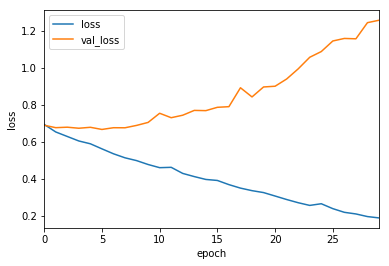

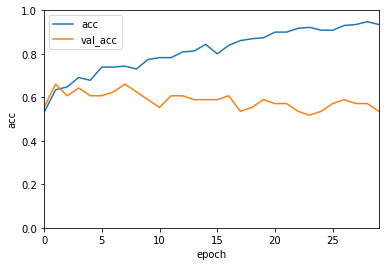

In [18]:
from tensorflow.compat.v1.keras            import Sequential
from tensorflow.compat.v1.keras.layers     import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from keras.wrappers.scikit_learn           import KerasClassifier

def build_nn():
    nn = Sequential()    
    nn.add(Dense(units=32, activation='relu', input_dim=len(list_X_columns)))
    nn.add(Dense(units=128, activation='relu'))
    nn.add(Dense(units=16, activation='relu'))
    nn.add(Dense(units=1, activation='sigmoid'))
    nn.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])    
    return nn

NN_param = dict(nb_epoch= [10,20,30],batch_size= [10,20])
best_NN = grid_search_argo(dic_argo, 'NeuralNetwork',KerasClassifier(build_fn=build_nn,verbose=0), NN_param, X_train, y_train)

y_test_pred_NN =(best_NN.predict(X_test) > 0.5).reshape(-1,)
y_train_pred_NN =(best_NN.predict(X_train) > 0.5).reshape(-1,)
print('score_train=',100 * accuracy_score(y_train, y_train_pred_NN))
print('score_test=',100 * accuracy_score(y_test, y_test_pred_NN))

# 計算の実行
fit = best_NN.fit(X_train, y_train,
          epochs=30, # エポック：学習データを何巡するか（50回データをみて学習する）※小さくすると十分に学習できない。
          batch_size=10,# 100個データあったとしてもランダムに20個ずつ取り出して重みを更新する
          validation_data=(X_test, y_test),
          verbose=0# ログを非表示
) 

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

## 5-5. アンサンブル × アンサンブル
### 5-5-1. [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

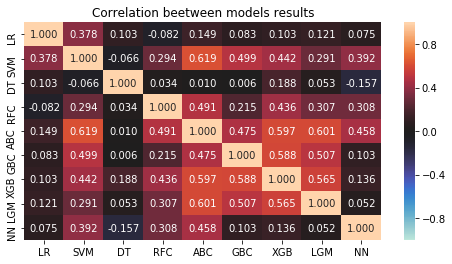

→相関の低いモデル同士を掛け合わせる。


In [19]:
# 各アルゴリズムの予測結果をヒートマップで比較
mdl_results = pd.concat([pd.Series(best_lr.predict(X_test), name="LR"), 
                         pd.Series(best_svm.predict(X_test), name="SVM"), 
                         pd.Series(best_dt.predict(X_test), name="DT"), 
                         pd.Series(best_RFC.predict(X_test), name="RFC"),
                         pd.Series(best_ABC.predict(X_test), name="ABC"),
                         pd.Series(best_GBC.predict(X_test), name="GBC"),
                         pd.Series(best_XGB.predict(X_test), name="XGB"),
                         pd.Series(best_LGB.predict(X_test), name="LGM"),
                         pd.Series(y_test_pred_NN, name="NN"),
                         ],axis=1)

plt.figure(figsize =(8, 4))
sns.heatmap(mdl_results.corr(), annot=True, fmt='1.3f', vmax=1, vmin=-1, center=0)
plt.title('Correlation beetween models results', size=12)
plt.show()

print('→相関の低いモデル同士を掛け合わせる。')

In [20]:
# 相関の高いモデル同士を掛け合わせる
VOC_clf = VotingClassifier(estimators=[('lr', best_lr),
                                       ('svm', best_svm),
                                       ('dt', best_dt),
                                       #('rfc', best_RFC),
                                       #('abc', best_ABC),
                                       ('gbc', best_GBC),
                                       ('xgb', best_XGB),
                                       ('lgb', best_LGB),
                                      ], n_jobs=-1)

VOC_param = {'voting': ['hard'],'weights':[None]}
best_VOC = grid_search_argo(dic_argo, 'VotingClassifier', VOC_clf, VOC_param, X_train, y_train)

best_VOC

BestScore: 0.591000 using {'voting': 'hard', 'weights': None}


VotingClassifier(estimators=[('lr', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='None',
   ...01, reg_lambda=0, silent=True,
        subsample=0.01, subsample_for_bin=200000, subsample_freq=0))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=None)

In [21]:
'''
plot_learning_curve(best_lr,"1.LogisticRegression learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_svm,"2.SVM learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_dt,"3.Decition Tree learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_RFC,"4.RandomForest learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_ABC,"5.AdaBoost learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_GBC,"6.GradientBoosting learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_XGB,"7.XGBoost learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_LGB,"8.LightGBM learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_NN,"9.Neural Network learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_VOC,"10.VotingClassifier learning curves",X_train,y_train,cv=kfold)
'''

'\nplot_learning_curve(best_lr,"1.LogisticRegression learning curves",X_train,y_train,cv=kfold)\nplot_learning_curve(best_svm,"2.SVM learning curves",X_train,y_train,cv=kfold)\nplot_learning_curve(best_dt,"3.Decition Tree learning curves",X_train,y_train,cv=kfold)\nplot_learning_curve(best_RFC,"4.RandomForest learning curves",X_train,y_train,cv=kfold)\nplot_learning_curve(best_ABC,"5.AdaBoost learning curves",X_train,y_train,cv=kfold)\nplot_learning_curve(best_GBC,"6.GradientBoosting learning curves",X_train,y_train,cv=kfold)\nplot_learning_curve(best_XGB,"7.XGBoost learning curves",X_train,y_train,cv=kfold)\nplot_learning_curve(best_LGB,"8.LightGBM learning curves",X_train,y_train,cv=kfold)\nplot_learning_curve(best_NN,"9.Neural Network learning curves",X_train,y_train,cv=kfold)\nplot_learning_curve(best_VOC,"10.VotingClassifier learning curves",X_train,y_train,cv=kfold)\n'

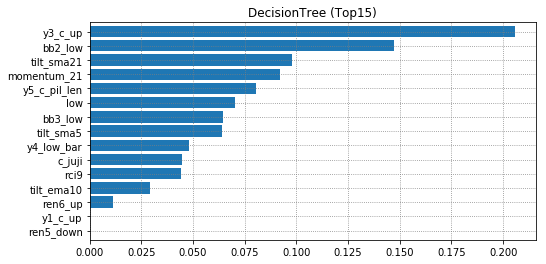

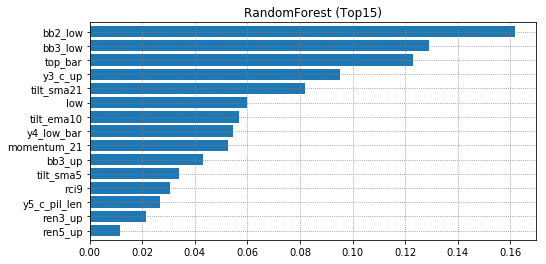

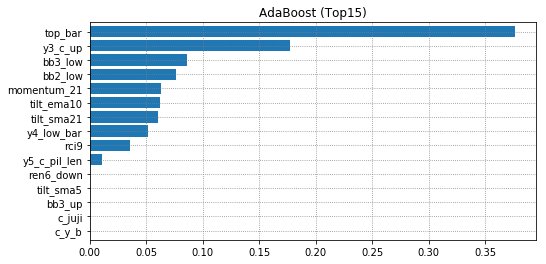

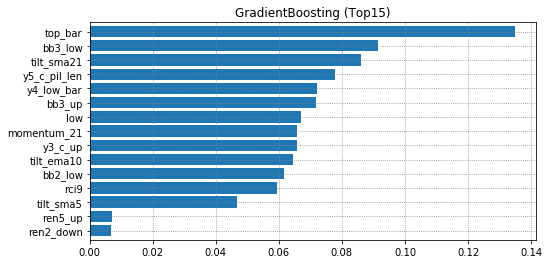

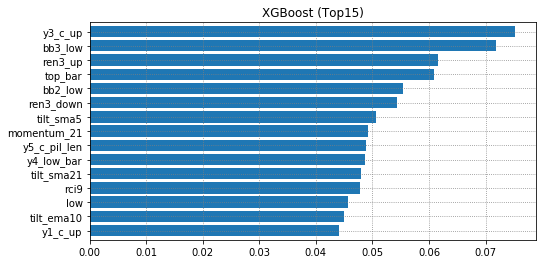

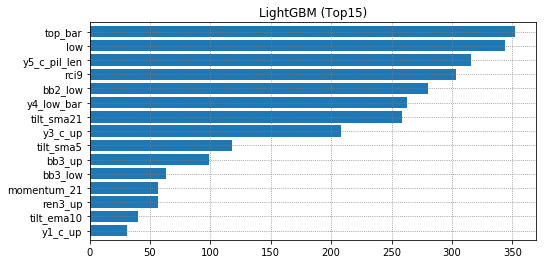

In [22]:
for k,grid_result in dic_argo.items():    
    if(hasattr(grid_result.best_estimator_, 'feature_importances_')):
        plot_feature_importance(grid_result.best_estimator_, list_X_columns, k)

## 6. モデル評価<a id='result'></a>

In [23]:
# 全モデルの評価結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['model_name','train_acc_score','test_acc_score','precision','recall','F1'])

# 全モデル比較
first_flg = True
for k,grid_result in dic_argo.items():
    tmp_score = grid_result.best_score_
    
    # 一覧追加
    y_train_pred = grid_result.best_estimator_.predict(X_train)
    y_test_pred = grid_result.best_estimator_.predict(X_test)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
    addRow = pd.DataFrame([k, 100 * accuracy_score(y_train, y_train_pred),
                              100 * accuracy_score(y_test, y_test_pred),
                              100 * precision[0],
                              100 * recall[0],
                              100 * f1_score[0]], index=res_df.columns).T
    res_df = res_df.append(addRow, ignore_index=True)
    
    # 最良モデル取得
    if (first_flg):
        max_score = tmp_score
        best_model = k
        best_clf = grid_result.best_estimator_
        best_param = grid_result.best_params_
        first_flg = False
    if (max_score < tmp_score):
        max_score = tmp_score
        best_model = k
        best_clf = grid_result.best_estimator_
        best_param = grid_result.best_params_

print('\n▼ モデルの評価結果一覧')
display(res_df)

# 最良モデルの評価
y_train_pred = best_clf.predict(X_train) # 訓練データ
y_test_pred = best_clf.predict(X_test) # テストデータ
score_train = 100 * accuracy_score(y_train, y_train_pred)
score_test = 100 * accuracy_score(y_test, y_test_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
v_precision = 100 * precision[0]
v_recall= 100 * recall[0]
v_F1 = 100 * f1_score[0]

print('\n▼ Day3 モデルの評価結果')
print('最良モデル = ' + str(best_model) + '：' + str(best_param))
print('訓練データサイズ = ' + str(X_train.shape))
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_test_pred)))
print('正答率（訓練データ） = {:.3f}%'.format(score_train))
print('正答率（テストデータ）= {:.3f}% ※汎化性能'.format(score_test))
print('適合率（Precision※精度) = {:.3f}%'.format(v_precision))
print('再現率（Recall※検出率) = {:.3f}%'.format(v_recall))
print('F1値（F1-score） = {:.3f}%'.format(v_F1))
print('\n▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 翌日上昇しない', '正解 =翌日上昇する'], 
                        columns=['予測 = 翌日上昇しない', '予測 = 翌日上昇する'])
display(conf_mat)


▼ モデルの評価結果一覧


,model_name,train_acc_score,test_acc_score,precision,recall,F1
0,LogisticRegression,65.2174,48.2143,51.4286,60,55.3846
1,SVM,70.8696,55.3571,59.2593,53.3333,56.1404
2,DecisionTree,70.8696,48.2143,51.5152,56.6667,53.9683
3,RandomForest,69.5652,57.1429,57.5,76.6667,65.7143
4,AdaBoost,74.7826,64.2857,65.625,70,67.7419
5,GradientBoosting,100,62.5,66.6667,60,63.1579
6,XGBoost,97.3913,62.5,63.6364,70,66.6667
7,LightGBM,86.9565,62.5,64.5161,66.6667,65.5738
8,NeuralNetwork,95.6522,53.5714,57.1429,53.3333,55.1724
9,VotingClassifier,87.3913,55.3571,56.7568,70,62.6866



▼ Day3 モデルの評価結果
最良モデル = SVM：{'C': 0.1, 'kernel': 'linear'}
訓練データサイズ = (230, 23)
対数尤度 = -15.419
正答率（訓練データ） = 70.870%
正答率（テストデータ）= 55.357% ※汎化性能
適合率（Precision※精度) = 59.259%
再現率（Recall※検出率) = 53.333%
F1値（F1-score） = 56.140%

▼ 混同行列


,予測 = 翌日上昇しない,予測 = 翌日上昇する
正解 = 翌日上昇しない,16,14
正解 =翌日上昇する,11,15


In [24]:
printmd('▼ 閾値以上の信頼度でトレードした場合の勝率')
# 確率取得（上昇しない確率：上昇する確率）
prob = best_clf.predict_proba(X_test)

# 閾値を指定
max_prob, max_prob_args = [],[]
for i in range(len(prob)):
    max_prob.append(prob[i].max())
    if prob[i].max() > 0.60: # n%以上の確率データで絞る
        max_prob_args.append(prob[i].argmax())
    else:
        max_prob_args.append(-1)
a = pd.DataFrame(X_test)
a['pred'] = max_prob_args
a['actual'] = y_test
a['max_prob'] = max_prob
b = a[a['pred'] != -1]
display(b[['pred','actual','max_prob']].head(10))
print('正答率（※閾値指定）={:.3f}%'.format(accuracy_score(b['pred'], b['actual']) * 100))

printmd('▼ 明日の予測')
test_csv =X_today_df
test_csv['tomorrow_pred'] = best_clf.predict(X_today)
test_csv['prob0'] = best_clf.predict_proba(X_today)[:,0]
test_csv['prob1'] = best_clf.predict_proba(X_today)[:,1]
test_csv = test_csv.reset_index()
test_csv = test_csv[['time','open','high','low','close','tomorrow_pred','prob0','prob1']]
display(test_csv)

print('Probability of rising the next day = {:.2f}%'.format(test_csv.iloc[0,7] * 100))



**▼ 閾値以上の信頼度でトレードした場合の勝率**

,pred,actual,max_prob
0,0,0,0.661762
1,1,0,0.767344
3,0,0,0.634120
4,0,0,0.761877
8,0,1,0.668658
9,1,0,0.623908
10,0,0,0.657411
11,0,1,0.603160
12,0,0,0.697820
13,0,0,0.646038


正答率（※閾値指定）=58.333%




**▼ 明日の予測**

,time,open,high,low,close,tomorrow_pred,prob0,prob1
0,2020-02-08 03:00:00,109.812,109.853,109.707,109.799,0,0.539209,0.460791


Probability of rising the next day = 46.08%
